## Dataset Selection
- kalshi/polymarket market and trade data obtained using: https://github.com/Jon-Becker/prediction-market-analysis
- Kalshi Trades: 72 million
- Kalshi Markets: 7.6 million
- This is a complex dataset

In [32]:
# imports
import duckdb
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
from typing import Dict, List

import time

In [11]:
# dataset analysis
con = duckdb.connect()
query = f"""
SELECT count(*)
FROM 'data/kalshi/trades/*.parquet'
"""

df = con.execute(query).df()
df.head()


,count_star()
0,72134741


In [ ]:
# dataset analysis
con = duckdb.connect()
query = f"""
SELECT count(*)
FROM 'data/kalshi/markets/*.parquet'
"""

df = con.execute(query).df()
df.head()


,count_star()
0,7682445


In [20]:
# dataset analysis with all features
con = duckdb.connect()
query = f"""
SELECT *
FROM 'data/kalshi/trades/*.parquet' t
    JOIN 'data/kalshi/markets/*.parquet' m USING (ticker)
LIMIT 10
"""

df = con.execute(query).df()
df.head()


,trade_id,ticker,count,yes_price,no_price,taker_side,created_time,_fetched_at,event_ticker,market_type,...,no_ask,last_price,volume,volume_24h,open_interest,result,created_time_1,open_time,close_time,_fetched_at_1
0,5df4ade0-f927-461a-8bc0-d7e23b2cc038,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:26.539290-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565
1,1168cd56-9895-470d-83ab-d6673f821f75,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:18.168809-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565
2,121d116c-ce75-4e9e-8e08-965f6094e62e,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:09.413934-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565
3,f3c052d1-bd82-4284-9b23-77d97d8125f0,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:01.219108-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565
4,f6b42645-bb32-40a1-b5e9-ae1ba414323f,-23MAR-T2,10,1,99,yes,2023-03-27 16:27:01.209590-07:00,2025-11-25 01:20:41.474248,SNOWNYM-23MAR,binary,...,100,1,400,0,157,no,2023-03-10 06:51:51.708324-08:00,2023-03-10 07:00:00-08:00,2023-04-03 07:00:00-07:00,2025-11-24 02:38:17.446565


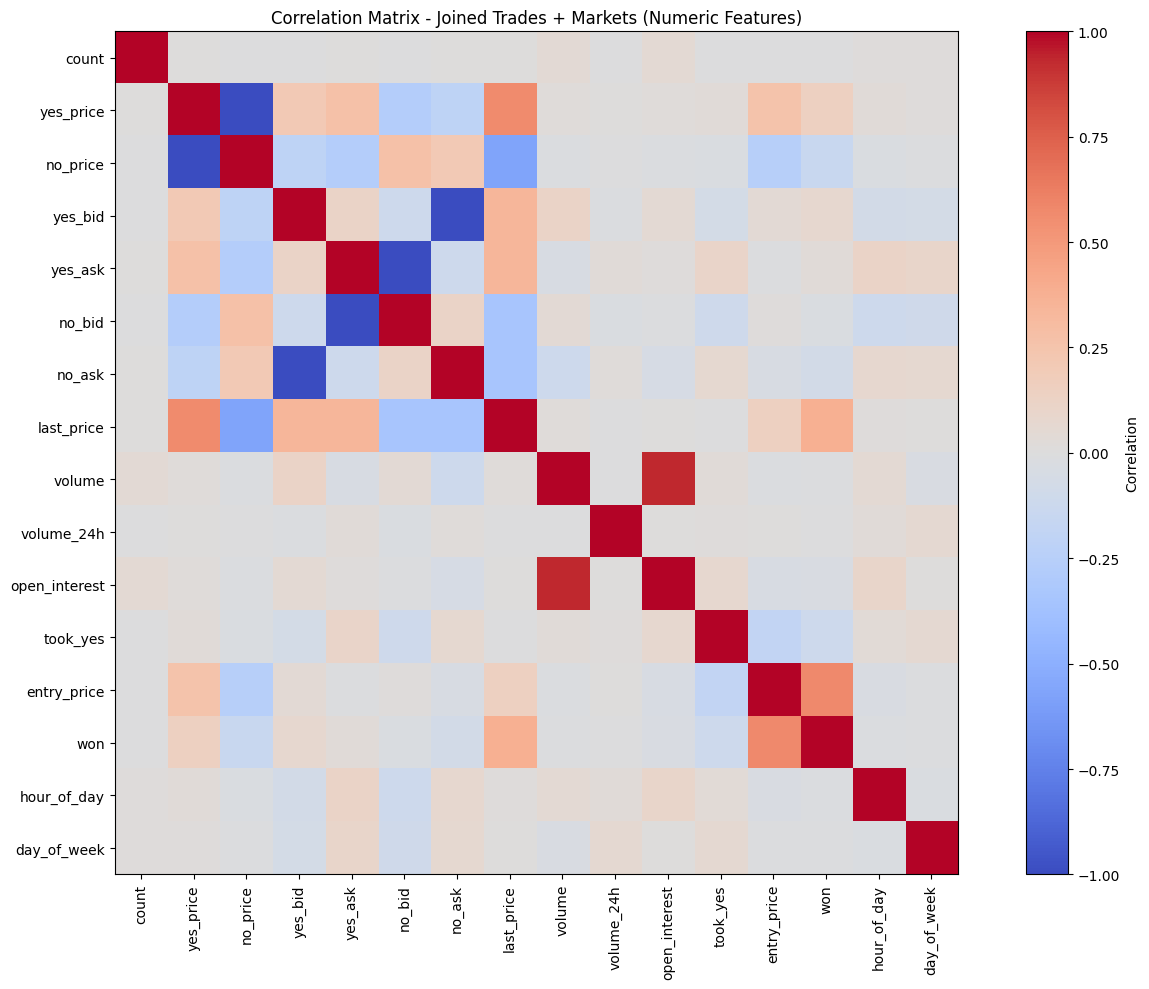

In [25]:
# feature engineering: correlation analysis on joined trades + markets
FEATURE_SAMPLE_ROWS = 100000

con = duckdb.connect()
joined_query = f"""
SELECT *
FROM 'data/kalshi/trades/*.parquet' t
JOIN 'data/kalshi/markets/*.parquet' m USING (ticker)
WHERE m.status = 'finalized'
  AND m.result IN ('yes', 'no')
  AND t.count > 0
  AND t.yes_price BETWEEN 1 AND 99
  AND t.no_price BETWEEN 1 AND 99
USING SAMPLE {FEATURE_SAMPLE_ROWS} ROWS (reservoir)
"""

feature_df = con.execute(joined_query).df()

# target + trade-context engineered features
feature_df['took_yes'] = (feature_df['taker_side'] == 'yes').astype(float)
feature_df['entry_price'] = np.where(
    feature_df['taker_side'] == 'yes',
    feature_df['yes_price'],
    feature_df['no_price'],
).astype(float) / 100.0
feature_df['won'] = (feature_df['taker_side'] == feature_df['result']).astype(float)
feature_df['hour_of_day'] = feature_df['created_time'].dt.hour.astype(float)
feature_df['day_of_week'] = feature_df['created_time'].dt.dayofweek.astype(float)

# scale market/trade prices to probabilities where applicable
for price_col in ['yes_price', 'no_price', 'yes_bid', 'yes_ask', 'no_bid', 'no_ask', 'last_price']:
    if price_col in feature_df.columns:
        feature_df[price_col] = feature_df[price_col].astype(float) / 100.0

numeric_feature_df = feature_df.select_dtypes(include=[np.number]).copy()
corr_matrix = numeric_feature_df.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('Correlation Matrix - Joined Trades + Markets (Numeric Features)')
cbar = plt.colorbar()
cbar.set_label('Correlation')
plt.tight_layout()
plt.show()


In [26]:
# find features to select
won_corr = corr_matrix['won'].drop('won').sort_values(key=np.abs, ascending=False)
won_corr_df = won_corr.rename('corr_with_won').to_frame()
display(won_corr_df.head(20))

# pick candidate features by target correlation, then de-duplicate highly collinear columns
corr_threshold = 0.02
max_pairwise_corr = 0.95
candidate_features = won_corr_df.index[won_corr_df['corr_with_won'].abs() >= corr_threshold].tolist()

selected_feature_columns = []
for col in candidate_features:
    if not selected_feature_columns:
        selected_feature_columns.append(col)
        continue

    high_corr = any(
        abs(corr_matrix.loc[col, chosen_col]) >= max_pairwise_corr
        for chosen_col in selected_feature_columns
    )
    if not high_corr:
        selected_feature_columns.append(col)

print('Selected features to move forward with:')
print(selected_feature_columns)
print(f'Total selected: {len(selected_feature_columns)}')

,corr_with_won
entry_price,0.572218
last_price,0.376250
yes_price,0.143927
no_price,-0.143880
took_yes,-0.110726
no_ask,-0.072660
yes_bid,0.072660
open_interest,-0.032524
no_bid,-0.026682
yes_ask,0.026682


Selected features to move forward with:
['entry_price', 'last_price', 'yes_price', 'took_yes', 'no_ask', 'open_interest', 'no_bid', 'hour_of_day']
Total selected: 8


,entry_price,last_price,yes_price,took_yes,yes_bid,open_interest,no_bid,won
entry_price,1.000000,0.146960,0.254486,-0.186947,0.039730,-0.041578,0.009715,0.571452
last_price,0.146960,1.000000,0.567386,-0.007384,0.337029,0.005102,-0.336411,0.383327
yes_price,0.254486,0.567386,1.000000,0.021225,0.197772,0.027151,-0.270877,0.143866
took_yes,-0.186947,-0.007384,0.021225,1.000000,-0.070099,0.062920,-0.105109,-0.111032
yes_bid,0.039730,0.337029,0.197772,-0.070099,1.000000,0.053576,-0.108387,0.069868
open_interest,-0.041578,0.005102,0.027151,0.062920,0.053576,1.000000,-0.013808,-0.037173
no_bid,0.009715,-0.336411,-0.270877,-0.105109,-0.108387,-0.013808,1.000000,-0.031772
won,0.571452,0.383327,0.143866,-0.111032,0.069868,-0.037173,-0.031772,1.000000


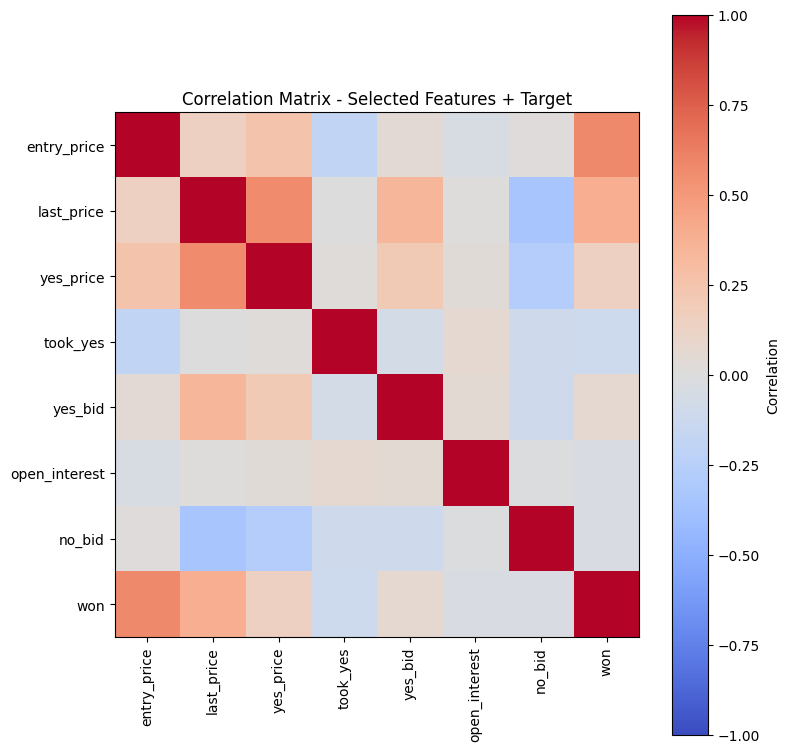

,entry_price,last_price,yes_price,took_yes,yes_bid,open_interest,no_bid,won
0,0.38,0.99,0.62,0.0,0.99,2494105,0.0,0.0
1,0.28,0.01,0.28,1.0,0.00,9156835,0.0,0.0
2,0.59,0.01,0.41,0.0,0.00,32602,0.0,1.0
3,0.19,0.01,0.19,1.0,0.00,39625,0.0,0.0
4,0.29,0.99,0.29,1.0,0.00,61068,0.0,1.0


In [24]:
# correlation matrix for selected features (+ target)
selected_cols_with_target = selected_feature_columns + ['won'] if selected_feature_columns else ['won']
selected_corr_matrix = feature_df[selected_cols_with_target].corr(numeric_only=True)

display(selected_corr_matrix)

plot_size = max(8, int(len(selected_cols_with_target) * 0.8))
plt.figure(figsize=(plot_size, plot_size))
plt.imshow(selected_corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(len(selected_corr_matrix.columns)), selected_corr_matrix.columns, rotation=90)
plt.yticks(range(len(selected_corr_matrix.index)), selected_corr_matrix.index)
plt.title('Correlation Matrix - Selected Features + Target')
cbar = plt.colorbar()
cbar.set_label('Correlation')
plt.tight_layout()
plt.show()

# preview rows for selected feature set
feature_df[selected_cols_with_target].head()


## Part 1: home grown nn

In [37]:

@dataclass
class TrainHistory:
    losses: List[float]


class NeuralNetwork:
    def __init__(
        self,
        layer_sizes: List[int],
        learning_rate: float = 0.01,
        random_seed: int | None = None,
    ) -> None:
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.rng = np.random.default_rng(random_seed)

        self.parameters: Dict[str, np.ndarray] = {}
        self.caches: Dict[str, np.ndarray] = {}
        self._initialize_parameters()

    def _initialize_parameters(self) -> None:
        self.parameters.clear()
        for layer in range(1, len(self.layer_sizes)):
            fan_in = self.layer_sizes[layer - 1]
            fan_out = self.layer_sizes[layer]
            self.parameters[f"W{layer}"] = self.rng.standard_normal(
                (fan_out, fan_in)
            ) * np.sqrt(2.0 / fan_in)
            self.parameters[f"b{layer}"] = np.zeros((fan_out, 1))

    @staticmethod
    def _relu(z: np.ndarray) -> np.ndarray:
        return np.maximum(0.0, z)

    @staticmethod
    def _relu_derivative(z: np.ndarray) -> np.ndarray:
        return (z > 0).astype(float)

    @staticmethod
    def _sigmoid(z: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-z))

    def forward_propagation(self, x: np.ndarray) -> np.ndarray:
        a = x
        self.caches = {"A0": x}
        last_layer = len(self.layer_sizes) - 1

        for layer in range(1, last_layer):
            w = self.parameters[f"W{layer}"]
            b = self.parameters[f"b{layer}"]
            z = w @ a + b
            a = self._relu(z)
            self.caches[f"Z{layer}"] = z
            self.caches[f"A{layer}"] = a

        z_last = (
            self.parameters[f"W{last_layer}"] @ a + self.parameters[f"b{last_layer}"]
        )
        a_last = self._sigmoid(z_last)
        self.caches[f"Z{last_layer}"] = z_last
        self.caches[f"A{last_layer}"] = a_last
        return a_last

    def cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
        m = y_true.shape[1]
        loss = (
            -np.sum(y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred)) / m
        )
        return float(loss)

    def backward_propagation(
        self, x: np.ndarray, y_true: np.ndarray
    ) -> Dict[str, np.ndarray]:
        m = x.shape[1]
        last_layer = len(self.layer_sizes) - 1
        grads: Dict[str, np.ndarray] = {}

        a_last = self.caches[f"A{last_layer}"]
        d_z = a_last - y_true

        for layer in range(last_layer, 0, -1):
            a_prev = self.caches[f"A{layer - 1}"]
            w = self.parameters[f"W{layer}"]

            grads[f"dW{layer}"] = (d_z @ a_prev.T) / m
            grads[f"db{layer}"] = np.sum(d_z, axis=1, keepdims=True) / m

            if layer > 1:
                z_prev = self.caches[f"Z{layer - 1}"]
                d_a_prev = w.T @ d_z
                d_z = d_a_prev * self._relu_derivative(z_prev)

        return grads

    def _gradient_descent_step(self, grads: Dict[str, np.ndarray]) -> None:
        for layer in range(1, len(self.layer_sizes)):
            self.parameters[f"W{layer}"] -= self.learning_rate * grads[f"dW{layer}"]
            self.parameters[f"b{layer}"] -= self.learning_rate * grads[f"db{layer}"]

    def _iterate_batches(
        self,
        x: np.ndarray,
        y_true: np.ndarray,
        batch_size: int,
        shuffle: bool,
    ):
        sample_count = x.shape[1]
        if shuffle:
            indices = self.rng.permutation(sample_count)
            x_epoch = x[:, indices]
            y_epoch = y_true[:, indices]
        else:
            x_epoch = x
            y_epoch = y_true

        for start in range(0, sample_count, batch_size):
            end = min(start + batch_size, sample_count)
            yield x_epoch[:, start:end], y_epoch[:, start:end]

    def train(
        self,
        x: np.ndarray,
        y_true: np.ndarray,
        epochs: int = 1000,
        print_every: int = 100,
        gradient_descent: str = "batch",
        batch_size: int = 32,
        shuffle: bool = True,
    ) -> TrainHistory:
        mode = gradient_descent.lower()
        sample_count = x.shape[1]
        if mode == "batch":
            effective_batch_size = sample_count
        elif mode == "mini-batch":
            effective_batch_size = min(batch_size, sample_count)
        elif mode == "stochastic":
            effective_batch_size = 1
        else:
            raise ValueError(
                "gradient_descent must be one of: batch, mini-batch, stochastic"
            )

        losses: List[float] = []

        for epoch in range(1, epochs + 1):
            for x_batch, y_batch in self._iterate_batches(
                x=x,
                y_true=y_true,
                batch_size=effective_batch_size,
                shuffle=shuffle,
            ):
                self.forward_propagation(x_batch)
                grads = self.backward_propagation(x_batch, y_batch)
                self._gradient_descent_step(grads)

            y_pred = self.forward_propagation(x)
            loss = self.cost(y_true, y_pred)
            losses.append(loss)

            if print_every > 0 and (
                epoch == 1 or epoch % print_every == 0 or epoch == epochs
            ):
                print(f"Epoch {epoch}/{epochs} - loss: {loss:.6f}")

        return TrainHistory(losses=losses)

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        return self.forward_propagation(x)

    def predict(self, x: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        probabilities = self.predict_proba(x)
        return (probabilities >= threshold).astype(int)


In [38]:
# train/test split + Step 1 experiment loops (from-scratch NN)
TRAIN_FRACTION = 0.8

# Use selected engineered features from the feature-engineering section
X_full = feature_df[selected_feature_columns].to_numpy(dtype=np.float64)
y_full = feature_df['won'].to_numpy(dtype=np.float64).reshape(-1, 1)

split_rng = np.random.default_rng(42)
indices = split_rng.permutation(X_full.shape[0])
split_idx = int(TRAIN_FRACTION * X_full.shape[0])
train_idx = indices[:split_idx]
test_idx = indices[split_idx:]

X_train_raw = X_full[train_idx]
X_test_raw = X_full[test_idx]
y_train = y_full[train_idx].T
y_test = y_full[test_idx].T

# Normalize using train statistics only
mu = X_train_raw.mean(axis=0, keepdims=True)
sigma = X_train_raw.std(axis=0, keepdims=True)
sigma[sigma == 0] = 1.0

X_train = ((X_train_raw - mu) / sigma).T
X_test = ((X_test_raw - mu) / sigma).T

print('Selected features:', selected_feature_columns)
print('train features shape:', X_train.shape)
print('train labels shape:  ', y_train.shape)
print('test features shape: ', X_test.shape)
print('test labels shape:   ', y_test.shape)


Selected features: ['entry_price', 'last_price', 'yes_price', 'took_yes', 'no_ask', 'open_interest', 'no_bid', 'hour_of_day']
train features shape: (8, 75076)
train labels shape:   (1, 75076)
test features shape:  (8, 18770)
test labels shape:    (1, 18770)


In [50]:
# experiments

def accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(y_true == y_pred))


def run_experiment(
    label: str,
    mode: str,
    epochs: int,
    batch_size: int = 256,
    learning_rate: float | None = None,
):
    learning_rate_by_mode = {
        'batch': 0.1,
        'mini-batch': 0.015,
        'stochastic': 0.003,
    }
    lr = learning_rate if learning_rate is not None else learning_rate_by_mode.get(mode, 0.03)

    model = NeuralNetwork(
        layer_sizes=[X_train.shape[0], 16, 8, 1],
        learning_rate=lr,
        random_seed=7,
    )

    train_kwargs = {
        'epochs': epochs,
        'print_every': max(1, epochs // 5),
        'gradient_descent': mode,
        'shuffle': True,
    }
    if mode == 'mini-batch':
        train_kwargs['batch_size'] = batch_size

    start = time.perf_counter()
    history = model.train(X_train, y_train, **train_kwargs)
    elapsed = time.perf_counter() - start

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return {
        'label': label,
        'mode': mode,
        'learning_rate': lr,
        'epochs': epochs,
        'batch_size': (batch_size if mode == 'mini-batch' else None),
        'runtime_sec': elapsed,
        'final_loss': history.losses[-1],
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'loss_curve': history.losses,
    }



Running: Batch GD
Epoch 1/500 - loss: 0.725790
Epoch 100/500 - loss: 0.347456
Epoch 200/500 - loss: 0.087129
Epoch 300/500 - loss: 0.041222
Epoch 400/500 - loss: 0.032479
Epoch 500/500 - loss: 0.029604

Running: Mini-batch GD (256)
Epoch 1/20 - loss: 0.610035
Epoch 4/20 - loss: 0.116374
Epoch 8/20 - loss: 0.035223
Epoch 12/20 - loss: 0.029182
Epoch 16/20 - loss: 0.027823
Epoch 20/20 - loss: 0.027278

Running: Stochastic GD
Epoch 1/20 - loss: 0.026340
Epoch 4/20 - loss: 0.025377
Epoch 8/20 - loss: 0.023915
Epoch 12/20 - loss: 0.022904
Epoch 16/20 - loss: 0.021347
Epoch 20/20 - loss: 0.020626


,label,mode,learning_rate,epochs,batch_size,runtime_sec,final_loss,train_accuracy,test_accuracy
1,Mini-batch GD (256),mini-batch,0.015,20,256.0,0.544687,0.027278,0.993020,0.993660
0,Batch GD,batch,0.100,500,NaN,7.314062,0.029604,0.992967,0.993181
2,Stochastic GD,stochastic,0.003,20,NaN,44.993365,0.020626,0.993420,0.993873


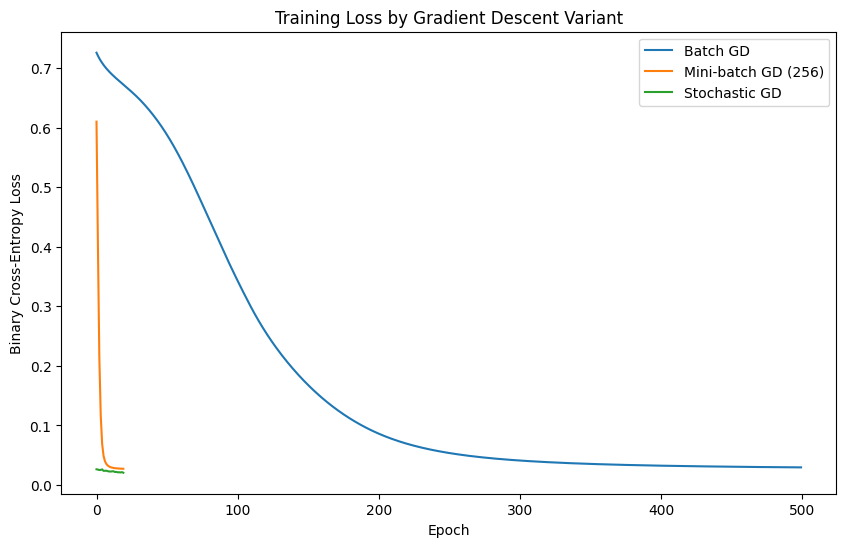

In [53]:
experiments = [
    {'label': 'Batch GD', 'mode': 'batch', 'epochs': 500},
    {'label': 'Mini-batch GD (256)', 'mode': 'mini-batch', 'epochs': 20, 'batch_size': 256},
    {'label': 'Stochastic GD', 'mode': 'stochastic', 'epochs': 20},
]

results = []
for exp in experiments:
    print(f"\nRunning: {exp['label']}")
    result = run_experiment(
        label=exp['label'],
        mode=exp['mode'],
        epochs=exp['epochs'],
        batch_size=exp.get('batch_size', 256),
        learning_rate=exp.get('learning_rate'),
    )
    results.append(result)

results_df = pd.DataFrame([
    {k: v for k, v in item.items() if k != 'loss_curve'}
    for item in results
]).sort_values('runtime_sec')

display(results_df)

plt.figure(figsize=(10, 6))
for item in results:
    plt.plot(item['loss_curve'], label=item['label'])

plt.title('Training Loss by Gradient Descent Variant')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.show()

batch_runtime = float(results_df.loc[results_df['mode'] == 'batch', 'runtime_sec'].iloc[0])
mini_runtime = float(results_df.loc[results_df['mode'] == 'mini-batch', 'runtime_sec'].iloc[0])